In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from textblob import TextBlob
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import spacy

2.1 adding age field 

In [8]:
df = pd.read_csv('Quote.csv')
df['Author\'s name'].unique()
df['Age'] = df['Author\'s date of birth'].apply(lambda x: 2024 - datetime.strptime(x, '%Y-%m-%d').year)
df.head()

,Author's name,Author's link,Author's date of birth,Author's famous quote,Age
0,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145
1,J.K. Rowling,https://quotes.toscrape.com//author/J-K-Rowling,1965-07-31,“It is impossible to live without failing at s...,59
2,Jane Austen,https://quotes.toscrape.com//author/Jane-Austen,1775-12-16,“I declare after all there is no enjoyment lik...,249
3,Marilyn Monroe,https://quotes.toscrape.com//author/Marilyn-Mo...,1926-06-01,“You believe lies so you eventually learn to t...,98
4,André Gide,https://quotes.toscrape.com//author/Andre-Gide,1869-11-22,“It is better to be hated for what you are tha...,155


2.2 Data Exploration

In [9]:
df_athors = pd.read_csv('Quotes_Of_Authors.csv')
df_categories = pd.read_csv('Category_Of_Authors.csv')
df_athors.head()
result = pd.merge(df, df_athors[['Author\'s name', 'Author\'s famous quotes']], 
                 on='Author\'s name', 
                 how='left')
result = pd.merge(result, df_categories[['Author\'s name', 'Author\'s category']], 
                 on='Author\'s name', 
                 how='left')
result.rename(columns={'Author\'s famous quotes': 'Other famous quotes'}, inplace=True)
result['Author\'s date of birth'] = pd.to_datetime(result['Author\'s date of birth'])  

In [10]:
result.head()

,Author's name,Author's link,Author's date of birth,Author's famous quote,Age,Other famous quotes,Author's category
0,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145,“The world as we have created it is a process ...,change | deep-thoughts | thinking | world | in...
1,J.K. Rowling,https://quotes.toscrape.com//author/J-K-Rowling,1965-07-31,“It is impossible to live without failing at s...,59,"“It is our choices, Harry, that show what we t...",abilities | choices | courage | friends | dumb...
2,Jane Austen,https://quotes.toscrape.com//author/Jane-Austen,1775-12-16,“I declare after all there is no enjoyment lik...,249,"“The person, be it gentleman or lady, who has ...",aliteracy | books | classic | humor | friendsh...
3,Marilyn Monroe,https://quotes.toscrape.com//author/Marilyn-Mo...,1926-06-01,“You believe lies so you eventually learn to t...,98,"“Imperfection is beauty, madness is genius and...",be-yourself | inspirational | friends | heartb...
4,André Gide,https://quotes.toscrape.com//author/Andre-Gide,1869-11-22,“It is better to be hated for what you are tha...,155,“It is better to be hated for what you are tha...,life | love


2.2 Data exploration

In [11]:
#unique author names
print("Number of authors in total \n",result['Author\'s name'].nunique())
print("\n".join(f"{i}: {name}" for i, name in enumerate(result["Author's name"].unique())))

Number of authors in total 
 50
0: Albert Einstein
1: J.K. Rowling
2: Jane Austen
3: Marilyn Monroe
4: André Gide
5: Thomas A. Edison
6: Eleanor Roosevelt
7: Steve Martin
8: Bob Marley
9: Dr. Seuss
10: Douglas Adams
11: Elie Wiesel
12: Friedrich Nietzsche
13: Mark Twain
14: Allen Saunders
15: Pablo Neruda
16: Ralph Waldo Emerson
17: Mother Teresa
18: Garrison Keillor
19: Jim Henson
20: Charles M. Schulz
21: William Nicholson
22: Jorge Luis Borges
23: George Eliot
24: George R.R. Martin
25: C.S. Lewis
26: Martin Luther King Jr.
27: James Baldwin
28: Haruki Murakami
29: Alexandre Dumas fils
30: Stephenie Meyer
31: Ernest Hemingway
32: Helen Keller
33: George Bernard Shaw
34: Charles Bukowski
35: Suzanne Collins
36: J.R.R. Tolkien
37: Alfred Tennyson
38: Terry Pratchett
39: J.D. Salinger
40: George Carlin
41: John Lennon
42: W.C. Fields
43: Ayn Rand
44: Jimi Hendrix
45: J.M. Barrie
46: E.E. Cummings
47: Khaled Hosseini
48: Harper Lee
49: Madeleine L'Engle


In [12]:
def process_quote_category(quote_category: pd.Series):
    quote_category = quote_category.str.split('|') 
    quote_category = quote_category.apply(lambda x: [i.strip().strip('"') for i in x])  # Strip whitespace
    return quote_category
 
def quote_statistic(df: pd.DataFrame, name: str):
    df = df[df['Author\'s name'] == name]  
    quote = df['Other famous quotes']
    quote = process_quote_category(quote)  
    print(quote)
  # Flatten the lists into individual rows
    quote = quote.explode().reset_index(drop=True)
    print(quote)

    quote_lengths = [len(i.split()) for i in quote] 
    idxmax = quote_lengths.index(max(quote_lengths))
    idxmin = quote_lengths.index(min(quote_lengths))
    longest_quote = quote.iloc[idxmax].strip()  # Convert to string
    shortest_quote = quote.iloc[idxmin].strip()  # Convert to string

    print("Number of quotes: ", len(quote))
    print("Average words per quote: ", np.mean(quote_lengths))
    print(f"Longest quote (length: {max(quote_lengths)}): \"{longest_quote}\"")
    print(f"Shortest quote (length: {min(quote_lengths)}): \"{shortest_quote}\"")
quote_statistic(result, 'J.K. Rowling')

1    [“It is our choices, Harry, that show what we ...
Name: Other famous quotes, dtype: object
0    “It is our choices, Harry, that show what we t...
1    “It takes a great deal of bravery to stand up ...
2    “It is impossible to live without failing at s...
3    “Of course it is happening inside your head, H...
4    “To the well-organized mind, death is but the ...
5    “It matters not what someone is born, but what...
6    “Do not pity the dead, Harry. Pity the living,...
7    “Remember, if the time should come when you ha...
8    “The truth." Dumbledore sighed. "It is a beaut...
Name: Other famous quotes, dtype: object
Number of quotes:  9
Average words per quote:  22.0
Longest quote (length: 46): "“Remember, if the time should come when you have to make a choice between what is right and what is easy, remember what happened to a boy who was good, and kind, and brave, because he strayed across the path of Lord Voldemort. Remember Cedric Diggory.”"
Shortest quote (length: 11): "“To

In [13]:
spacy_nlp = spacy.load('en_core_web_sm')
stop_words = spacy_nlp.Defaults.stop_words
len(stop_words)

326

Other famous quotes
great       3
live        3
pity        2
stand       2
remember    2
boy         1
time        1
come        1
choice      1
right       1
Name: count, dtype: int64


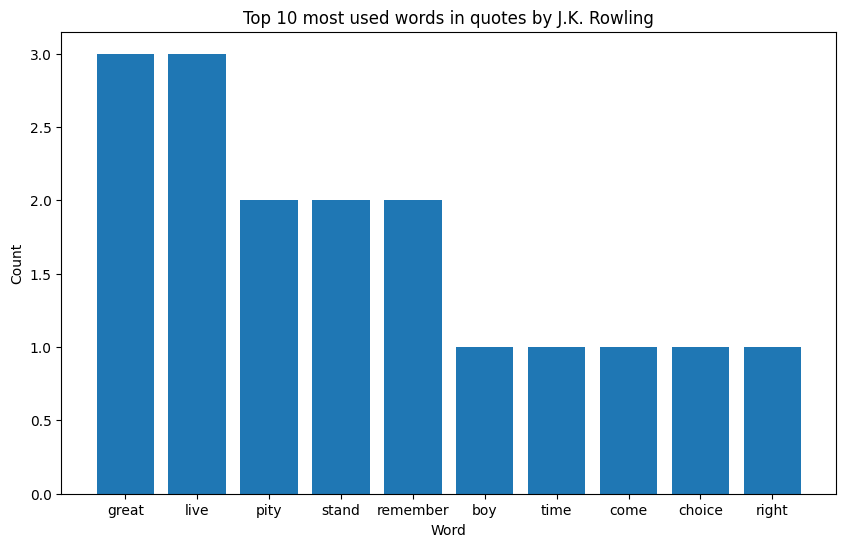

Other famous quotes
love      13
think     11
like       8
going      7
live       7
time       6
people     6
let        5
great      5
life       5
Name: count, dtype: int64


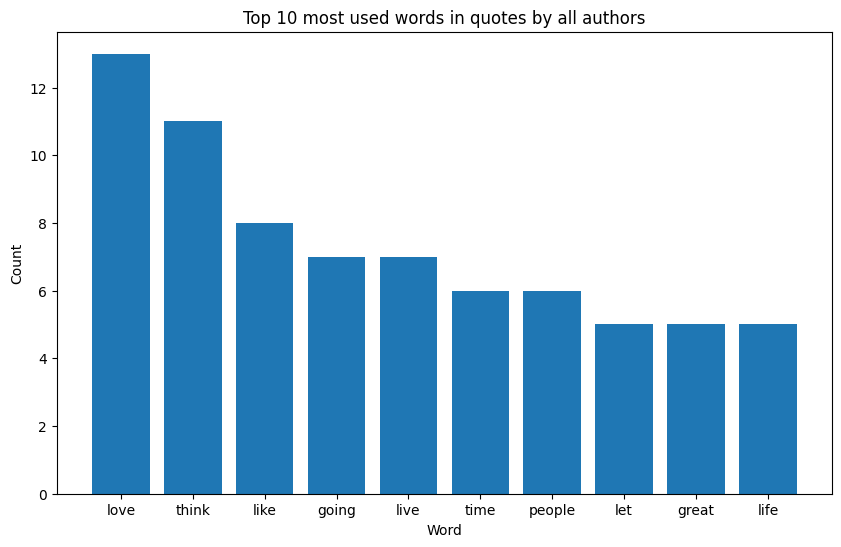

In [14]:
def most_word_used_in_quotes(df: pd.DataFrame, name: str = None, all_authors: bool = False):
    
    spacy_nlp = spacy.load('en_core_web_sm')
    stop_words = spacy_nlp.Defaults.stop_words
    if not all_authors and (name is not None):
        df = df[df['Author\'s name'] == name]  
    quote = df['Other famous quotes']
    quote = process_quote_category(quote)  
    quote = quote.explode().reset_index(drop=True)
    quote = quote.str.split() 
    quote = quote.explode().reset_index(drop=True)
    quote = quote.str.lower() 
    quote = quote[quote.str.isalpha()]
    quote = quote[~quote.isin(stop_words)]    
    word_count = quote.value_counts()  
    print(word_count.head(10))
    plt.figure(figsize=(10, 6))
    plt.bar(word_count.head(10).index, word_count.head(10).values)
    if not all_authors: 
        plt.title(f"Top 10 most used words in quotes by {name}")
    else: 
        plt.title("Top 10 most used words in quotes by all authors")
    plt.xlabel("Word")
    plt.ylabel("Count")
    plt.show()
most_word_used_in_quotes(result, 'J.K. Rowling')
most_word_used_in_quotes(result, all_authors=True)

Oldest author:  Jane Austen 249 years old ,Born in: 1973
Youngest author:  Stephenie Meyer 51 years old ,Born in: 1775
Average age of authors:  120.46


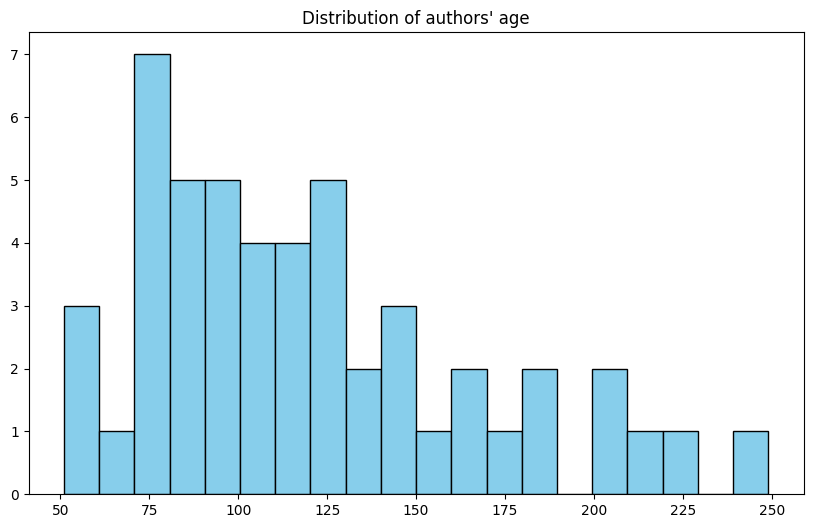

In [37]:

print("Oldest author: ", result['Author\'s name'][result['Age'].idxmax()], result['Age'].max(), "years old",",Born in:",result['Author\'s date of birth'].dt.year.max())  
print("Youngest author: ", result['Author\'s name'][result['Age'].idxmin()], result['Age'].min(), "years old", ",Born in:",result['Author\'s date of birth'].dt.year.min())
print("Average age of authors: ", result['Age'].mean())
plt.figure(figsize=(10, 6))
plt.hist(result['Age'], bins=20, color='skyblue', edgecolor='black')    
plt.title("Distribution of authors' age")
plt.savefig('age_distribution.png')
plt.show()


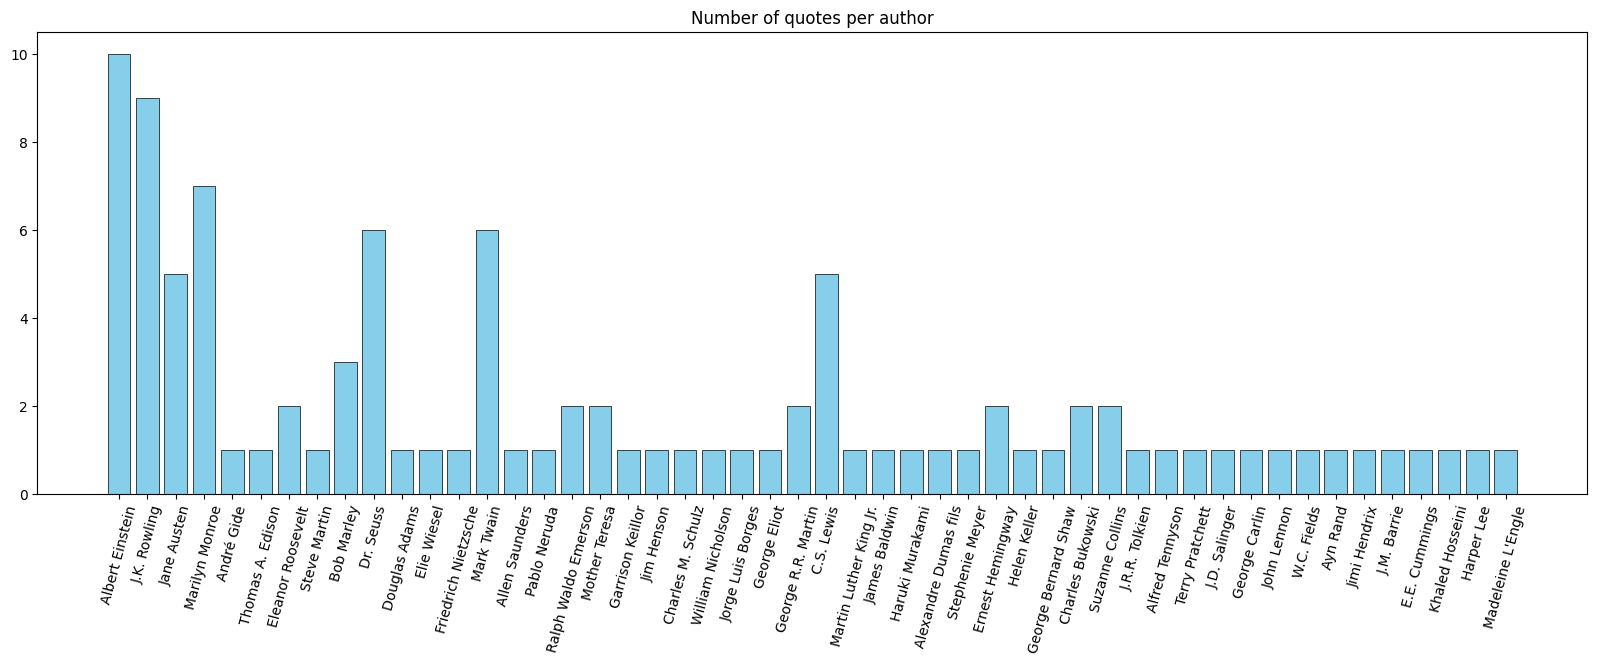

In [38]:
plt.figure(figsize=(20, 6)) 
plt.bar(result['Author\'s name'], [len(i.split('|')) for i in result['Other famous quotes']], color='skyblue', edgecolor='black', linewidth=0.5)
plt.xticks(rotation=75)
plt.title("Number of quotes per author")
plt.savefig('number_of_quotes_per_author.png')
plt.show()


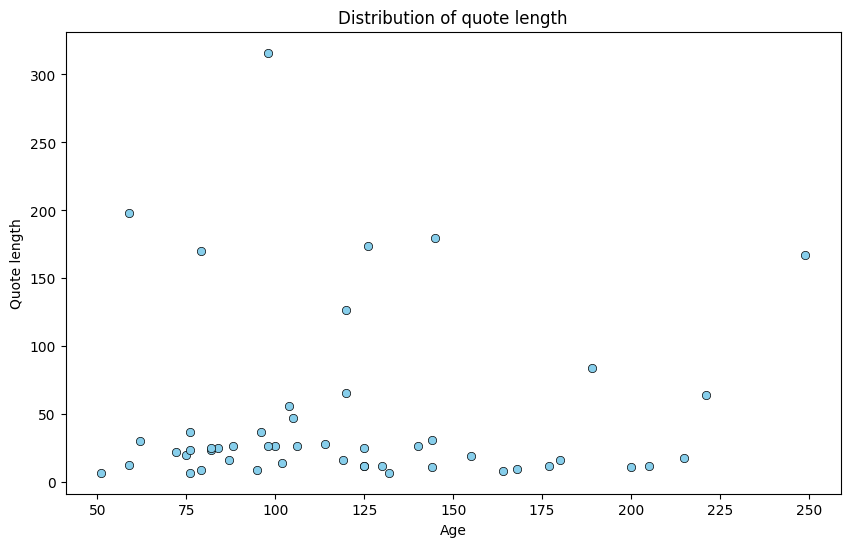

In [39]:
result['Quote length'] = result['Other famous quotes'].apply(
    lambda x: sum(len(i.strip('"').split()) for i in x.split('|'))
    )      
result.head()
plt.figure(figsize=(10, 6))
plt.scatter(result['Age'], result['Quote length'], color='skyblue', edgecolor='black', linewidth=0.5)
plt.title("Distribution of quote length")
plt.xlabel("Age")   
plt.ylabel("Quote length")
plt.savefig('quote_length_distribution.png')
plt.show()


2.3 Feature Extraction


In [18]:
def custom_tokenizer(text):
    return [token.lemma_ for token in spacy_nlp(text) if not token.is_stop and not token.is_punct]
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, binary =True ,max_features=300)
X = vectorizer.fit_transform(process_quote_category(result['Other famous quotes']).explode().reset_index(drop=True))
len(vectorizer.get_feature_names_out())      

C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


300

In [19]:
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [20]:
def analyze_sentiment(text, split : bool = True): #Split here to mark if that series is a list of quotes or a single quote True for list
    if split:
        text = text.split('|')
        text = [quote.strip('"') for quote in text]
        text = [TextBlob(i).sentiment.polarity for i in text]
        return np.mean(text)
    else:
        text = text.strip('"')
        return TextBlob(text).sentiment.polarity
def pos_distribution(text, split : bool = True):#Split here to mark if that series is a list of quotes or a single quote True for list
    text = text.split('|')
    text = [quote.strip('"') for quote in text]
    text = [TextBlob(i).sentiment.polarity for i in text]
    return sum(i > 0 for i in text) / len(text)

result['Sentiment'] = result['Other famous quotes'].apply(lambda x: analyze_sentiment(x))
result['Positive distribution'] = result['Other famous quotes'].apply(lambda x: pos_distribution(x))
result.head()

,Author's name,Author's link,Author's date of birth,Author's famous quote,Age,Other famous quotes,Author's category,Quote length,Sentiment,Positive distribution
0,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145,“The world as we have created it is a process ...,change | deep-thoughts | thinking | world | in...,180,0.132652,0.600000
1,J.K. Rowling,https://quotes.toscrape.com//author/J-K-Rowling,1965-07-31,“It is impossible to live without failing at s...,59,"“It is our choices, Harry, that show what we t...",abilities | choices | courage | friends | dumb...,198,0.179459,0.666667
2,Jane Austen,https://quotes.toscrape.com//author/Jane-Austen,1775-12-16,“I declare after all there is no enjoyment lik...,249,"“The person, be it gentleman or lady, who has ...",aliteracy | books | classic | humor | friendsh...,167,0.229583,0.800000
3,Marilyn Monroe,https://quotes.toscrape.com//author/Marilyn-Mo...,1926-06-01,“You believe lies so you eventually learn to t...,98,"“Imperfection is beauty, madness is genius and...",be-yourself | inspirational | friends | heartb...,316,0.148537,0.714286
4,André Gide,https://quotes.toscrape.com//author/Andre-Gide,1869-11-22,“It is better to be hated for what you are tha...,155,“It is better to be hated for what you are tha...,life | love,19,0.100000,1.000000


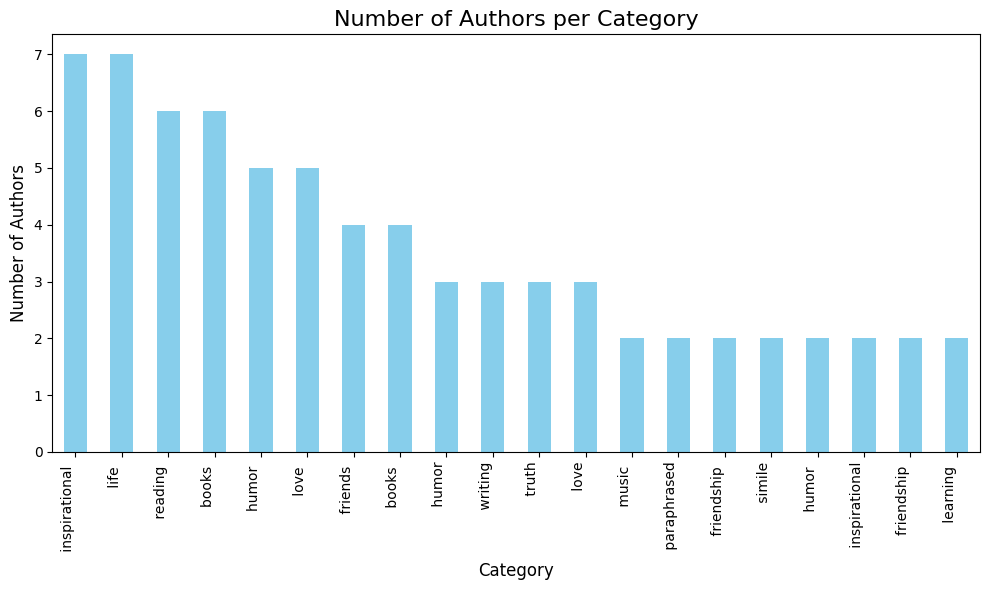

In [40]:
test_1 = result.copy()
test_1['Author\'s category'] = result['Author\'s category'].str.split('|')
test_1_explodede= test_1.explode('Author\'s category')
author_counts = test_1_explodede.groupby('Author\'s category')['Author\'s name'].nunique()
author_counts
plt.figure(figsize=(10, 6))
author_counts.sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
plt.title('Number of Authors per Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Authors', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig('number_of_authors_per_category.png')
plt.show()


In [22]:
result.to_csv('Analyze_Quotes.csv', index=False)

In [23]:
result_1 = result.copy()
result_1['Other famous quotes'] = result_1['Other famous quotes'].str.split('|')
expanded_result = result_1.explode('Other famous quotes', ignore_index=True)
expanded_result['Other famous quotes'] = expanded_result['Other famous quotes'].str.strip('"').str.strip()
expanded_result['Sentiment'] = expanded_result['Other famous quotes'].apply(lambda x: analyze_sentiment(x, split=False))
expanded_result['Quote length'] = expanded_result['Other famous quotes'].apply(lambda x: len(x.split()))
expanded_result.head()

,Author's name,Author's link,Author's date of birth,Author's famous quote,Age,Other famous quotes,Author's category,Quote length,Sentiment,Positive distribution
0,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145,“The world as we have created it is a process ...,change | deep-thoughts | thinking | world | in...,21,0.000000,0.6
1,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145,“There are only two ways to live your life. On...,change | deep-thoughts | thinking | world | in...,26,0.003788,0.6
2,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145,“Try not to become a man of success. Rather be...,change | deep-thoughts | thinking | world | in...,14,0.300000,0.6
3,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145,"“If you can't explain it to a six year old, yo...",change | deep-thoughts | thinking | world | in...,15,0.100000,0.6
4,Albert Einstein,https://quotes.toscrape.com//author/Albert-Ein...,1879-03-14,“Any fool can know. The point is to understand.”,145,"“If you want your children to be intelligent, ...",change | deep-thoughts | thinking | world | in...,25,0.650000,0.6


In [24]:
feature_df = pd.concat([expanded_result['Author\'s name'], X_df, expanded_result[['Sentiment', 'Positive distribution','Quote length']]], axis=1)
feature_df.to_csv('feature_df.csv', index=False)
len(X_df)

100

2.3 Data Mining

In [25]:
feature_df['Author\'s name'].unique()

array(['Albert Einstein', 'J.K. Rowling', 'Jane Austen', 'Marilyn Monroe',
       'André Gide', 'Thomas A. Edison', 'Eleanor Roosevelt',
       'Steve Martin', 'Bob Marley', 'Dr. Seuss', 'Douglas Adams',
       'Elie Wiesel', 'Friedrich Nietzsche', 'Mark Twain',
       'Allen Saunders', 'Pablo Neruda', 'Ralph Waldo Emerson',
       'Mother Teresa', 'Garrison Keillor', 'Jim Henson',
       'Charles M. Schulz', 'William Nicholson', 'Jorge Luis Borges',
       'George Eliot', 'George R.R. Martin', 'C.S. Lewis',
       'Martin Luther King Jr.', 'James Baldwin', 'Haruki Murakami',
       'Alexandre Dumas fils', 'Stephenie Meyer', 'Ernest Hemingway',
       'Helen Keller', 'George Bernard Shaw', 'Charles Bukowski',
       'Suzanne Collins', 'J.R.R. Tolkien', 'Alfred Tennyson',
       'Terry Pratchett', 'J.D. Salinger', 'George Carlin', 'John Lennon',
       'W.C. Fields', 'Ayn Rand', 'Jimi Hendrix', 'J.M. Barrie',
       'E.E. Cummings', 'Khaled Hosseini', 'Harper Lee',
       "Madeleine L'E

In [26]:
X = feature_df.drop('Author\'s name', axis=1)
y = feature_df['Author\'s name']
print(len(X) == len(y))


True


In [27]:
label_encode = LabelEncoder()
y = label_encode.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

In [28]:
base_classifiers = [
    ('nb' , GaussianNB()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)),
    ('gb', GradientBoostingClassifier(random_state=42, n_estimators=100)),
]
meta_classifier = LogisticRegression(random_state=42, n_jobs=-1)    
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=StratifiedKFold(n_splits=5))
stacking_classifier.fit(X_train, y_train)


C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:1415: RuntimeWarning: Number of classes in training fold (37) does not match total number of classes (43). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:1415: RuntimeWarning: Number of classes in training fold (37) does not match total number of cl

StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x1CA85088C40, shuffle=False),
                   estimators=[('nb', GaussianNB()),
                               ('rf',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression(n_jobs=-1,
                                                      random_state=42))

In [29]:
y_predict = stacking_classifier.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          26       0.33      0.33      0.33         3
          30       0.00      0.00      0.00         1
          37       0.11      1.00      0.20         1
          38       0.17      1.00      0.29         1
          39       0.00      0.00      0.00         1
          43       0.00      0.00      0.00         1

    accuracy                           0.25        20
   macro avg       0.10   

C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

## Consine Similarity

In [30]:
df = df[['Author\'s name', 'Author\'s famous quote']]
df

,Author's name,Author's famous quote
0,Albert Einstein,“Any fool can know. The point is to understand.”
1,J.K. Rowling,“It is impossible to live without failing at s...
2,Jane Austen,“I declare after all there is no enjoyment lik...
3,Marilyn Monroe,“You believe lies so you eventually learn to t...
4,André Gide,“It is better to be hated for what you are tha...
5,Thomas A. Edison,"“I have not failed. I've just found 10,000 way..."
6,Eleanor Roosevelt,“Do one thing every day that scares you.”
7,Steve Martin,"“A day without sunshine is like, you know, nig..."
8,Bob Marley,"“The truth is, everyone is going to hurt you. ..."
9,Dr. Seuss,“Think left and think right and think low and ...


In [31]:
tf_idf = TfidfVectorizer(tokenizer=custom_tokenizer, binary=True, max_features=300)
tf_idf_mat = tf_idf.fit_transform(df['Author\'s famous quote'])
tf_idf_mat = pd.DataFrame(tf_idf_mat.toarray(), columns=tf_idf.get_feature_names_out())
consine = cosine_similarity(tf_idf_mat)
consine = pd.DataFrame(consine, index=df['Author\'s name'], columns=df['Author\'s name'])
consine.head()

C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Author's name,Albert Einstein,J.K. Rowling,Jane Austen,Marilyn Monroe,André Gide,Thomas A. Edison,Eleanor Roosevelt,Steve Martin,Bob Marley,Dr. Seuss,...,George Carlin,John Lennon,W.C. Fields,Ayn Rand,Jimi Hendrix,J.M. Barrie,E.E. Cummings,Khaled Hosseini,Harper Lee,Madeleine L'Engle
Author's name,,,,,,,,,,,,,,,,,,,,,
Albert Einstein,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.175343,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.301298,0.000000
J.K. Rowling,0.0,1.0,0.0,0.0,0.0,0.153693,0.000000,0.000000,0.0,0.0,...,0.0,0.124768,0.000000,0.0,0.124236,0.0,0.0,0.000000,0.000000,0.000000
Jane Austen,0.0,0.0,1.0,0.0,0.0,0.000000,0.125726,0.086264,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.062331,0.068073
Marilyn Monroe,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.185488,0.000000,0.000000
André Gide,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.261589,0.0,0.000000,0.0,0.0,0.292781,0.000000,0.000000


In [32]:
def most_similar_athors(consine: pd.DataFrame, author: str, top: int = 5):
    if author not in consine.index:
        return "Author not found"
    most_similar = consine[author].sort_values(ascending=False).head(top+1)
    most_similar = most_similar.drop(author)
    return most_similar

for i in df['Author\'s name']:
    print(f"Most similar authors to {i}:")
    print(most_similar_athors(consine, i))
    print()

Most similar authors to Albert Einstein:
Author's name
William Nicholson    0.315987
Harper Lee           0.301298
Steve Martin         0.175343
Pablo Neruda         0.101468
Alfred Tennyson      0.000000
Name: Albert Einstein, dtype: float64

Most similar authors to J.K. Rowling:
Author's name
Thomas A. Edison    0.153693
John Lennon         0.124768
Jimi Hendrix        0.124236
J.R.R. Tolkien      0.000000
James Baldwin       0.000000
Name: J.K. Rowling, dtype: float64

Most similar authors to Jane Austen:
Author's name
Haruki Murakami      0.265608
J.D. Salinger        0.159203
William Nicholson    0.155457
Jorge Luis Borges    0.127872
Eleanor Roosevelt    0.125726
Name: Jane Austen, dtype: float64

Most similar authors to Marilyn Monroe:
Author's name
Khaled Hosseini         0.185488
Albert Einstein         0.000000
Alfred Tennyson         0.000000
Haruki Murakami         0.000000
Alexandre Dumas fils    0.000000
Name: Marilyn Monroe, dtype: float64

Most similar authors to André 